<a href="https://colab.research.google.com/github/Kofi-Young/gitskills/blob/master/stock_rnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas_datareader.data as pdr
import time
import datetime
# general modules 
import pandas as pd
pd.options.display.max_rows = 10
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import random
import os
# Deep Learning modules 
import tensorflow as tf
import keras as keras
from keras.models import Sequential
from keras import metrics
from keras.layers import LSTM, Dense, Activation
import h5py
#sklearn and xgboost
from sklearn.metrics import mean_squared_log_error
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from sklearn import preprocessing

/usr/local/lib/python3.6/dist-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal
Using TensorFlow backend.


In [0]:
def stock_data_unpack(ticker, start_date, end_date):
    count = 0
    try:
        raw_data = pdr.get_data_yahoo(ticker, start_date, end_date)
    except ValueError:
        print("ValueError, trying again")
        count += 1
        if count < 9:
            time.sleep(random.randrange(10))
            get_stock_data(ticker, start_date, end_date)
        else:
            print("Yahoo error. I will Try in a second or so")
            time.sleep(range(10,60))
            get_stock_data(ticker, start_date, end_date) 
            
    stock_data = raw_data 
    stock_data.to_csv("raw_data.csv")

In [0]:
start = datetime(2016,9,11)
end =   datetime(2019,9,27)
seq_len = 1 
stock_data_unpack("^DJI", start_date=start, end_date=end)

In [0]:
df1=pd.read_csv("raw_data.csv", names=['Date','High','Low','Open','Close','Volume','Adj Close'], parse_dates=True)
df1=df1.rename(columns={'Open': 'Dow_Open', 'Close': 'Dow_Close','Volume': 'Dow_Volume','High': 'Dow_High','Low': 'Dow_Low'})
df1=df1.drop(['Adj Close'],axis=1)
df1=df1.drop([0], axis=0)

In [0]:
df1.head()

,Date,Dow_High,Dow_Low,Dow_Open,Dow_Close,Dow_Volume
1,2016-09-12,18358.689453125,17994.83984375,18028.94921875,18325.0703125,103260000
2,2016-09-13,18262.990234375,18028.060546875,18262.990234375,18066.75,102830000
3,2016-09-14,18163.48046875,17992.2109375,18073.390625,18034.76953125,103360000
4,2016-09-15,18250.109375,18015.490234375,18024.91015625,18212.48046875,99550000
5,2016-09-16,18217.2109375,18070.2109375,18217.2109375,18123.80078125,278510000


In [0]:

def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time index")
    plt.ylabel("Price Index")
    plt.grid(True)
def moving_average(t, window):
    return np.convolve(t, np.ones(window), 'valid') / window

In [0]:
series = df1['Dow_Close'].to_numpy().astype(float)
time = df1.index.values.astype(float)

In [0]:
series = df1['Dow_Close'].to_numpy().astype(float)
time = df1.index.values.astype(float)

maxval=np.max(series)
print('The maximum price is=',maxval)
series=series/maxval
maxT=np.max(time)
print('The number of simulated days is=',maxT)
time=time/maxT

The maximum price is= 27359.16015625
The number of simulated days is= 767.0


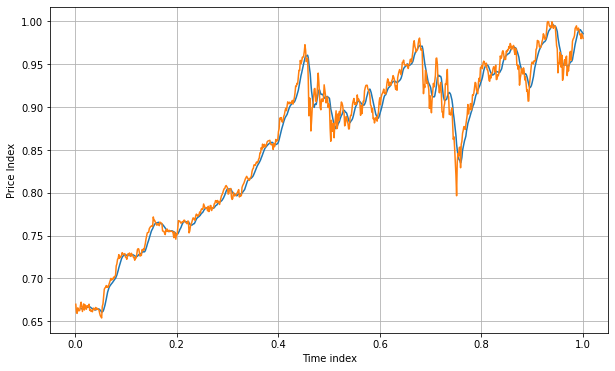

In [0]:

plt.figure(figsize=(10, 6))
window=9
plot_series(time[window-1:], moving_average(series,window))
plot_series(time, series)

In [0]:
split_time = 365
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 40#64 This parameter affects the results greatly as it will be seen
batch_size = 8
shuffle_buffer_size = 1000

In [0]:
print(tf.__version__)

2.2.0


In [0]:
def windowed_datasetII(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [0]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast


In [0]:
#------------------------------------------------
# Huber Loss
#------------------------------------------------
tf.keras.backend.clear_session()

train_set = windowed_datasetII(x_train, window_size, batch_size=batch_size, shuffle_buffer=shuffle_buffer_size)

model1 = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Dense(1),
])
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-6 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9)
model1.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history1 = model1.fit(train_set, epochs=100,verbose=2, callbacks=[lr_schedule])

#------------------------------------------------
# MAE loss
#------------------------------------------------
model2 = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Dense(1),
])
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-6 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9)
model2.compile(loss=tf.keras.losses.MeanAbsoluteError(),
              optimizer=optimizer,
              metrics=["mae"])
history2 = model2.fit(train_set, epochs=100,verbose=2, callbacks=[lr_schedule])

#------------------------------------------------
#     MSE loss
#------------------------------------------------
model3 = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Dense(1),
])
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-6 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9)
model3.compile(loss=tf.keras.losses.MeanSquaredError(),
              optimizer=optimizer,
              metrics=["mae"])
history3 = model3.fit(train_set, epochs=100,verbose=2, callbacks=[lr_schedule])

Epoch 1/100
41/41 - 2s - loss: 0.3124 - mae: 0.7873 - lr: 1.0000e-06
Epoch 2/100
41/41 - 1s - loss: 0.3113 - mae: 0.7859 - lr: 1.1220e-06
Epoch 3/100
41/41 - 1s - loss: 0.3099 - mae: 0.7842 - lr: 1.2589e-06
Epoch 4/100
41/41 - 1s - loss: 0.3084 - mae: 0.7823 - lr: 1.4125e-06
Epoch 5/100
41/41 - 1s - loss: 0.3068 - mae: 0.7802 - lr: 1.5849e-06
Epoch 6/100
41/41 - 1s - loss: 0.3049 - mae: 0.7778 - lr: 1.7783e-06
Epoch 7/100
41/41 - 1s - loss: 0.3028 - mae: 0.7751 - lr: 1.9953e-06
Epoch 8/100
41/41 - 1s - loss: 0.3005 - mae: 0.7722 - lr: 2.2387e-06
Epoch 9/100
41/41 - 1s - loss: 0.2980 - mae: 0.7688 - lr: 2.5119e-06
Epoch 10/100
41/41 - 1s - loss: 0.2951 - mae: 0.7651 - lr: 2.8184e-06
Epoch 11/100
41/41 - 1s - loss: 0.2920 - mae: 0.7610 - lr: 3.1623e-06
Epoch 12/100
41/41 - 1s - loss: 0.2884 - mae: 0.7564 - lr: 3.5481e-06
Epoch 13/100
41/41 - 1s - loss: 0.2846 - mae: 0.7512 - lr: 3.9811e-06
Epoch 14/100
41/41 - 1s - loss: 0.2802 - mae: 0.7454 - lr: 4.4668e-06
Epoch 15/100
41/41 - 1s - los

In [0]:
print(train_set)

<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>


(0.0, 0.1)

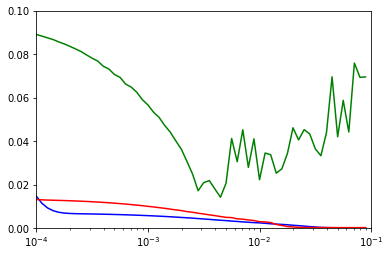

In [0]:
plt.semilogx(history1.history["lr"], history1.history["loss"],'b')
plt.semilogx(history2.history["lr"], history2.history["loss"],'g')
plt.semilogx(history3.history["lr"], history3.history["loss"],'r')
plt.xlim([1e-4,1e-1])
plt.ylim([0,1e-1])

In [0]:
tf.keras.backend.clear_session()
dataset = windowed_datasetII(x_train, window_size, batch_size, shuffle_buffer_size)
model = tf.keras.models.Sequential([tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 1)
])

optimizer = tf.keras.optimizers.SGD(lr=0.0891, momentum=0.9)
model.compile(loss=tf.keras.losses.MeanSquaredError(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(dataset,epochs=400)

Epoch 1/400
41/41 [==============================] - 2s 41ms/step - loss: 0.0527 - mae: 0.1576
Epoch 2/400
41/41 [==============================] - 2s 41ms/step - loss: 0.0059 - mae: 0.0605
Epoch 3/400
41/41 [==============================] - 2s 40ms/step - loss: 0.0053 - mae: 0.0581
Epoch 4/400
41/41 [==============================] - 2s 41ms/step - loss: 0.0047 - mae: 0.0543
Epoch 5/400
41/41 [==============================] - 2s 41ms/step - loss: 0.0054 - mae: 0.0569
Epoch 6/400
41/41 [==============================] - 2s 41ms/step - loss: 0.0049 - mae: 0.0548
Epoch 7/400
41/41 [==============================] - 2s 40ms/step - loss: 0.0047 - mae: 0.0541
Epoch 8/400
41/41 [==============================] - 2s 40ms/step - loss: 0.0045 - mae: 0.0529
Epoch 9/400
41/41 [==============================] - 2s 40ms/step - loss: 0.0042 - mae: 0.0516
Epoch 10/400
41/41 [==============================] - 2s 40ms/step - loss: 0.0033 - mae: 0.0459
Epoch 11/400
41/41 [=============================

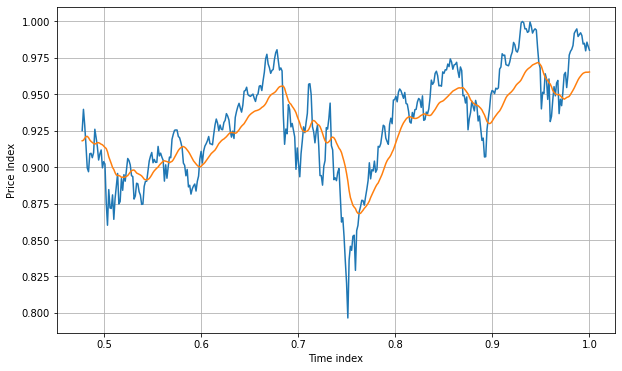

In [0]:

rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [38]:
window_size = 64
tf.keras.backend.clear_session()
dataset = windowed_datasetII(x_train, window_size, batch_size, shuffle_buffer_size)
model = tf.keras.models.Sequential([tf.keras.layers.Conv1D(filters=64, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 1)])
optimizer = tf.keras.optimizers.SGD(lr=0.0891, momentum=0.9)
model.compile(loss=tf.keras.losses.MeanSquaredError(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(dataset,epochs=400)

Epoch 1/400
38/38 [==============================] - 5s 136ms/step - loss: 0.0544 - mae: 0.1718
Epoch 2/400
38/38 [==============================] - 5s 137ms/step - loss: 0.0045 - mae: 0.0519
Epoch 3/400
38/38 [==============================] - 5s 138ms/step - loss: 0.0041 - mae: 0.0498
Epoch 4/400
38/38 [==============================] - 5s 140ms/step - loss: 0.0040 - mae: 0.0498
Epoch 5/400
38/38 [==============================] - 5s 139ms/step - loss: 0.0040 - mae: 0.0492
Epoch 6/400
38/38 [==============================] - 5s 138ms/step - loss: 0.0039 - mae: 0.0494
Epoch 7/400
38/38 [==============================] - 5s 139ms/step - loss: 0.0043 - mae: 0.0523
Epoch 8/400
38/38 [==============================] - 5s 139ms/step - loss: 0.0041 - mae: 0.0503
Epoch 9/400
38/38 [==============================] - 5s 142ms/step - loss: 0.0035 - mae: 0.0462
Epoch 10/400
38/38 [==============================] - 5s 140ms/step - loss: 0.0036 - mae: 0.0474
Epoch 11/400
38/38 [===================

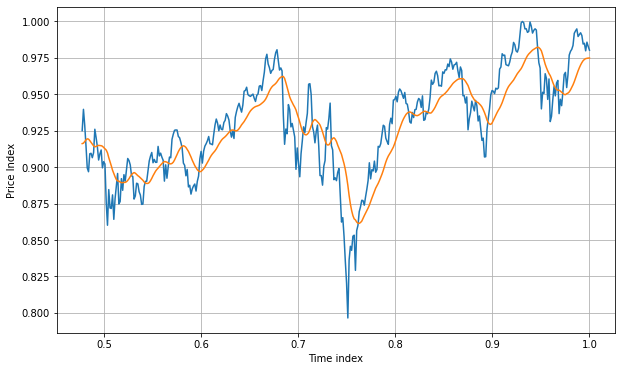

In [39]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)